In [1]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [17]:
%cd /content/drive/MyDrive/DLCV/project

/content/drive/MyDrive/DLCV/project


In [ ]:
!unzip /content/drive/MyDrive/DLCV/project/skull.zip -d /content/data/

## Import

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

import glob
import os
import numpy as np
from PIL import Image

import pandas
import json

from matplotlib import pyplot as plt

1116
32
{'path': 'H1_00000002_00000691/H1_00000002_00000691_00000001.npy', 'study': 'H1_00000002', 'coords': [], 'label': -1, 'series': 691}
{'path': 'H1_00000002_00000691/H1_00000002_00000691_00000002.npy', 'study': 'H1_00000002', 'coords': [], 'label': -1, 'series': 691}
{'path': 'H1_00000002_00000691/H1_00000002_00000691_00000003.npy', 'study': 'H1_00000002', 'coords': [], 'label': -1, 'series': 691}
{'path': 'H1_00000002_00000691/H1_00000002_00000691_00000004.npy', 'study': 'H1_00000002', 'coords': [], 'label': -1, 'series': 691}
{'path': 'H1_00000002_00000691/H1_00000002_00000691_00000005.npy', 'study': 'H1_00000002', 'coords': [], 'label': -1, 'series': 691}
{'path': 'H1_00000002_00000691/H1_00000002_00000691_00000006.npy', 'study': 'H1_00000002', 'coords': [], 'label': -1, 'series': 691}
{'path': 'H1_00000002_00000691/H1_00000002_00000691_00000007.npy', 'study': 'H1_00000002', 'coords': [], 'label': -1, 'series': 691}
{'path': 'H1_00000002_00000691/H1_00000002_00000691_00000008.

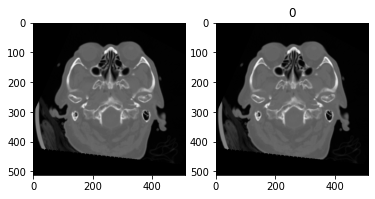

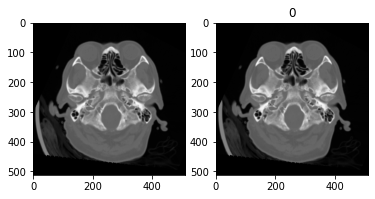

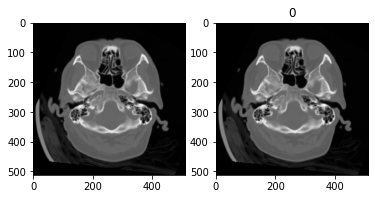

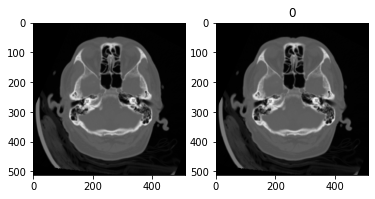

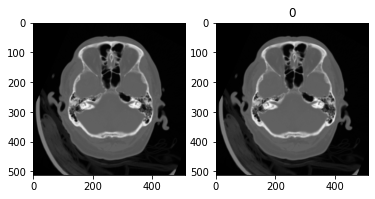

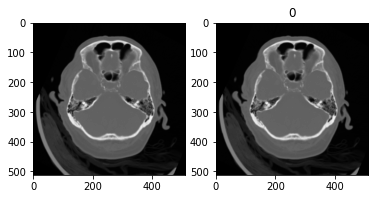

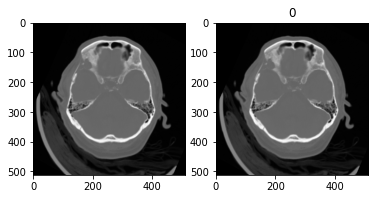

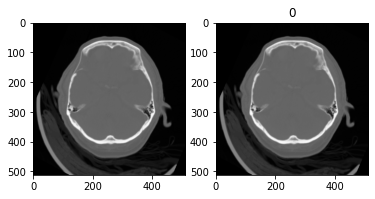

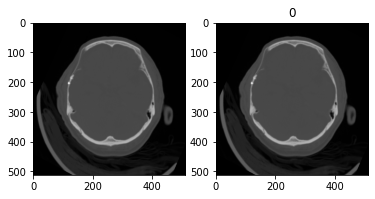

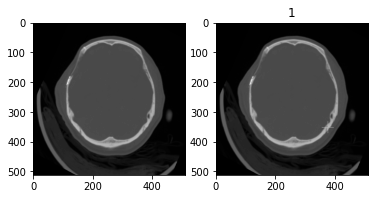

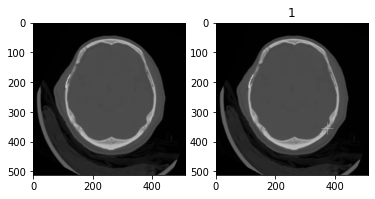

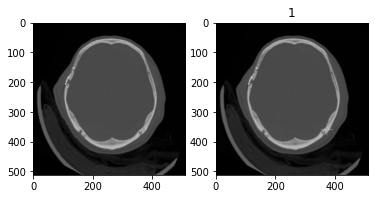

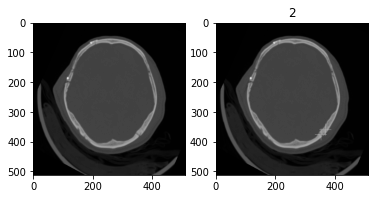

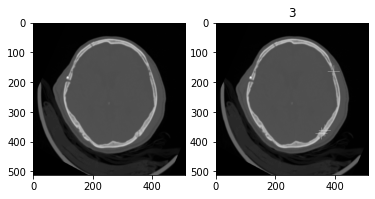

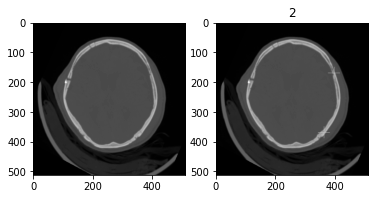

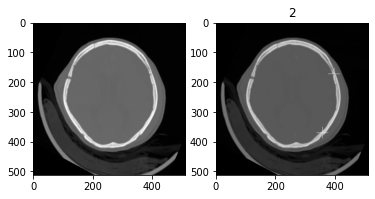

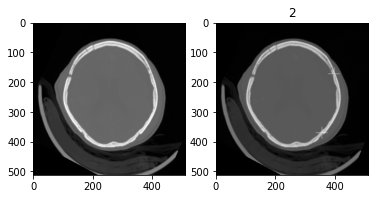

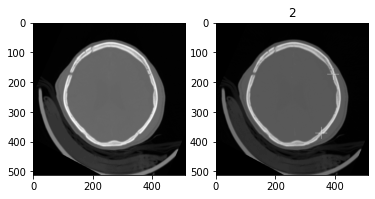

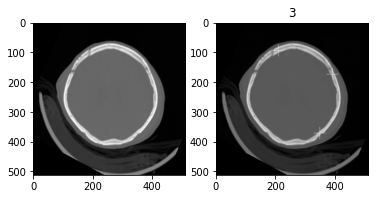

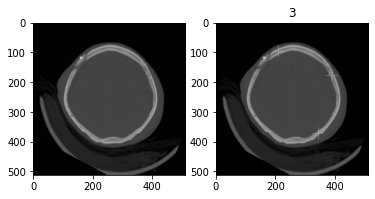

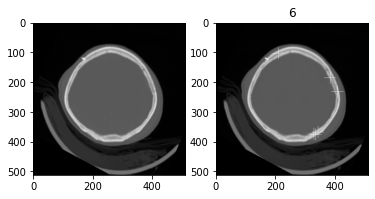

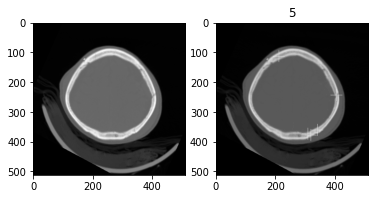

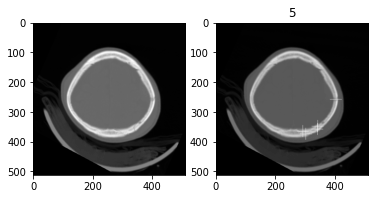

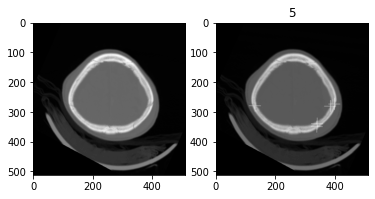

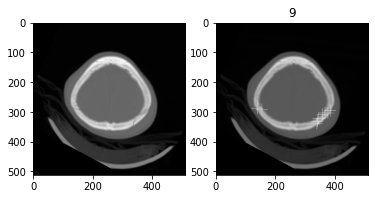

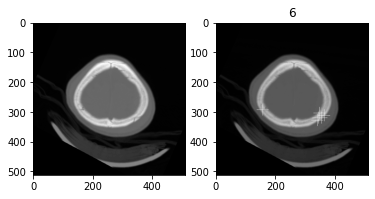

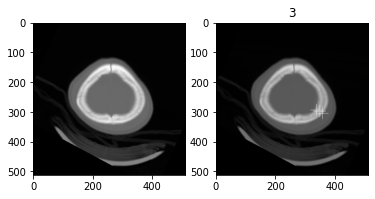

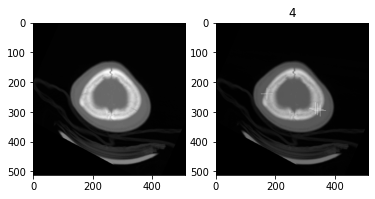

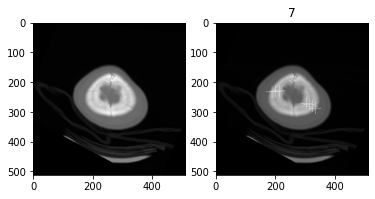

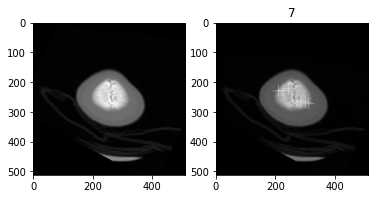

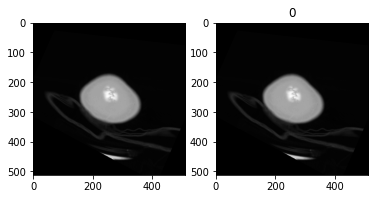

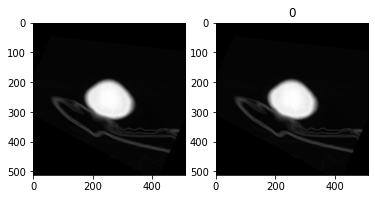

In [181]:
with open("./skull/records_train.json",'r') as f:
    data = json.load(f)
data = data["datainfo"] #32665
# path
# study
# coords
# label
# series

patients_data = {}
for patients in data:
    series = data[patients]["series"]
    if series not in patients_data:
        patients_data[series] = []
    patients_data[series].append(data[patients])

print(len(patients_data)) #1116
print(len(patients_data[691])) #30 series = 182
for i in patients_data[691]:
    print(i)

plt.figure()
for info in patients_data[691]:
    coords = info["coords"]
    img_array = np.load("./skull/train/"+info["path"])
    # img_array = img_array.transpose() #.npy image need transpose???
    plt.subplot(1,2,1)
    plt.imshow(img_array, cmap='gray')
    
    for i in coords: #[[208, 94], [347, 371], [390, 174]]
        for x in range(-20,20): # highlight the coords
            img_array[i[1]+x,i[0]] = 2000   #equivalent to transpose()
            img_array[i[1],i[0]+x] = 2000
    plt.subplot(1,2,2)
    plt.title(len(coords))
    plt.imshow(img_array, cmap='gray')
    plt.show()

# Sundry

## Dataset

In [ ]:
class Skullset(Dataset):
    def __init__(self, root, transform=None):
        self.data = []
        self.root = root
        self.transform = transform

        for file_name in sorted(os.listdir(self.root)):
            label, id = file_name.split('_')
            label = int(label)
            id = int(id[:-4])
            self.data.append((file_name,label,id))

        self.len = len(self.data)

    def __getitem__(self, index):
        image_fn, label, id = self.data[index]
        image = Image.open(os.path.join(self.root,image_fn))

        if self.transform is not None:
            image = self.transform(image)
        return image, label, id

    def __len__(self):
        return self.len


In [ ]:
position = [
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
]

crop = [
    transforms.CenterCrop(30),
    transforms.RandomCrop(28),
    transforms.RandomRotation(15)
]

all = [*position, *crop]

train_transform = transforms.Compose([
    transforms.RandomChoice(all),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                          
])

trainset = Imageset(root='./data/p1_data/train_50',
    transform=train_transform)

valset = Imageset(root='./data/p1_data/val_50',
    transform=val_transform)

print('# images in trainset:', len(trainset)) 
print('# images in testset:', len(valset)) 

# images in trainset: 22500
# images in testset: 2500


In [ ]:
batch_size = 64

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=8)

dataiter = iter(train_loader)
images, labels, id= dataiter.next()

print('Image tensor in each batch:', images.shape, images.dtype)
print('Label tensor in each batch:', labels.shape, labels.dtype)
print('ID tensor in each batch:', id.shape, id.dtype)
print(len(train_loader))
print(len(val_loader))

Image tensor in each batch: torch.Size([64, 3, 256, 256]) torch.float32
Label tensor in each batch: torch.Size([64]) torch.int64
ID tensor in each batch: torch.Size([64]) torch.int64
352
40


In [ ]:
torch.manual_seed(444)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device is ', device)

Device is  cuda


## Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.last_2 = models.resnet50(pretrained=True)
        self.last_1 = nn.Linear(1000,50) # classes = 50
    def forward(self,x):
        x = self.last_2(x)
        x = self.last_1(x)
        return x
#model = Net().to(device)
#print(model)

## Train utilites

In [ ]:
def train(model, epoch, lr, decay):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=decay)

    criterion= nn.CrossEntropyLoss()
    model.train()

    iteration = 0    
    best_acc = 0.
    for ep in range(epoch):

        train_correct = 0
        train_loss = 0
        
        for idx, (data,target,id) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()

            if iteration % 100 == 0:
                print(f'Train Epoch: {ep+1}/{epoch} {(100. * idx/len(train_loader)):.3f}% \tLoss:{(loss.item()):.3f}')
            iteration +=1

            pred = output.max(1, keepdim=True)[1] 
            train_correct += pred.eq(target.view_as(pred)).sum().item()
            train_loss += loss.item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * train_correct/len(train_loader.dataset)

        print(f'\nTrain_set:\t Loss: {train_loss:.4f} \t train_acc:{train_acc:.2f}%')

        val_acc, _ = val(model)
        if val_acc > best_acc:
            best_acc = val_acc
            model_path = '/content/drive/MyDrive/Colab Notebooks/DLCV/HW1/model_1/model_'+f'{best_acc:.2f}'+'.pth'
            
            if ep%50==0 or best_acc>80:
                torch.save(model.state_dict(),model_path)
                print(f'Saving model with acc {best_acc:.3f}\n')


In [ ]:
def val(model):
    criterion = nn.CrossEntropyLoss()
    model.eval()

    val_correct = 0
    val_loss = 0
    val_acc = 0
    pred_list = []

    with torch.no_grad():
        for data, target, id in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            pred = output.max(1, keepdim=True)[1] # output.shape=1000*50, 找50中最大的index
            acc = pred.eq(target.view_as(pred)).sum().item()
            
            pred_list.append((pred,id))

            val_correct += pred.eq(target.view_as(pred)).sum().item()
            val_loss += loss.item()

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct/len(val_loader.dataset)
        
        print(f'Val_set:\t Loss: {val_loss:.4f} \t Val_acc:{val_acc:.2f}%\n')
    return val_acc, pred_list

## Training

In [ ]:
lr = 0.0002
decay=1e-5
model = Net().to(device)
train(model, epoch=101, lr=lr, decay=decay)

## Loading

In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/DLCV/HW1/model_1/model_res50.pth'
model_load = Net().to(device)
model_load.load_state_dict(torch.load(PATH))
model_load.to(device)

In [ ]:
lr = 0.0001
decay=1e-5
train(model_load, epoch=500, lr=lr, decay=decay)

In [ ]:
# accuracy, pred_list = val(model)
accuracy, pred_list = val(model_load)

Val_set:	 Loss: 0.0095 	 Val_acc:82.48%



## Write t-SNE

In [ ]:
def get_last_2(model, path,size):
    device = 'cuda' if torch.cuda.is_available else 'cpu'
    labels = []
    i=0
    last_2_output = []

    with torch.no_grad():
        for name in os.listdir(path):
            i+=1
            labels.append( int(name.split('_')[0]))
            features = []
            def hook(module, input, output): 
                features.append(output.clone().detach())
            img = val_transform(Image.open(os.path.join(path,name))).to(device)
            img = img.unsqueeze(0)
            handle = model.last_2.register_forward_hook(hook)
            out = model(img)
            last_2_output.append(features[0].cpu())
            handle.remove()
            if i==size:
                break
    last_2_output = torch.cat(last_2_output)
    print(last_2_output.shape)
    return last_2_output, labels


In [ ]:
def tSNE(last_2_output, labels):
    X = last_2_output
    Y = labels
    X_sne = manifold.TSNE(n_components=2, init='random', random_state=10, perplexity=50, verbose=1).fit_transform(X)

    print(X_sne.shape)
    df = pandas.DataFrame(dict(Feature_1=X_sne[:,0], Feature_2=X_sne[:,1], label=Y))
    df.plot(x="Feature_1", y="Feature_2", kind='scatter',c='label', colormap='viridis',figsize=(9,9))


In [ ]:
path = './data/p1_data/val_50'
# last_2_output, labels = get_last_2(model, path, size=len(valset))
last_2_output, labels = get_last_2(model_load, path, size=1000)
tSNE(last_2_output,labels)

## Testing

In [ ]:
def test(model,path):
    model.eval()
    val_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                          
    ])
    filenames = []
    pred_list = {}
    device = 'cuda' if torch.cuda.is_available else 'cpu'
    with torch.no_grad():
        for name in os.listdir(path): # no sorted
            # i+=1
            if name.endswith('png'):
                img = val_transform(Image.open(os.path.join(path,name))).to(device)
                id = name[:-4]
                img = img.unsqueeze(0)
                output = model(img)
                pred = output.max(1, keepdim=True)[1] # output.shape=1000*50, 找50中最大的index
                pred_list[id] = pred.item()
                print(pred.item())
    return pred_list

## Write csv

In [ ]:
def write(path, pred_list):
    with open(path, "w") as f:

        # The first row must be "Id, Category"
        f.write("image_id,label\n")

        for id in pred_list:
            f.write(f"{id}.png,{pred_list[id]}\n")

In [ ]:
path = '/content/test/'
pred_list = test(model_load,path)
print(pred_list)
write('prediction.csv', pred_list)

15
0
39
33
16
12
{'0459': 15, '0450': 0, '0466': 39, '0499': 33, '0457': 16, '0453': 12}


In [ ]:
# !mv ./test/13_499.png ./test/0499.png
# !mv ./test/16_457.png ./test/0457.png

## Bash

In [ ]:
!bash hw1_1.sh /content/test/ pred.csv

## Sundry

In [ ]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

437617664
15437135872
437617664
1075838976


In [ ]:
a = torch.tensor([[1,2,3],
                  [2,3,4]])
b = torch.tensor([[2,2],
                  [3,3],
                  [4,4]])
c = b.view_as(a)

big = a.max(1,keepdim=True)[1]
print(big)

In [ ]:
!mv ./model_1/model_80.pth /content/drive/MyDrive/Colab\ Notebooks/DLCV/HW1/model_1

In [ ]:
a = torch.randn(1,5)
b = torch.randn(1,5)
c = torch.randn(1,5)
l = [a,b,c]
d = torch.cat(l)
print(d.shape)

torch.Size([3, 5])


In [ ]:
!bash test.sh

--2021-10-30 09:16:27--  https://www.dropbox.com/s/bxgui3h4mvtrouo/0_450.png?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/bxgui3h4mvtrouo/0_450.png [following]
--2021-10-30 09:16:27--  https://www.dropbox.com/s/dl/bxgui3h4mvtrouo/0_450.png
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4ca07974b24eda21b677628aea.dl.dropboxusercontent.com/cd/0/get/BZCp2bWkJXtlzDdvHI09dTAKeONtOcfDYn7ub9volKhtzXwnHxTc0D54Nbt-5MjbC0TR5OfGFsNEfhwg1E_SSkp9Nx75FhqmoYRq1dNbwxAz7Kc8Jph_rSmZGxo1mkd22v_5Xk82zHN7PcKng1yLt-0e/file?dl=1# [following]
--2021-10-30 09:16:28--  https://uc4ca07974b24eda21b677628aea.dl.dropboxusercontent.com/cd/0/get/BZCp2bWkJXtlzDdvHI09dTAKeONtOcfDYn7ub9volKhtzXwnHxTc0D54Nbt-5MjbC0TR5OfGFsNEfhwg1E_SSkp9Nx75Fh

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
import os

device = 'cuda'
# Step2: Define custom CNN
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        # create layers
        ## TODO ##
        self.layer = nn.Linear(3*32*32, 10)
    def forward(self, x):
        x = self.layer(x)
        return x

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.last_2 = models.resnet50(pretrained=True)
        self.last_1 = nn.Linear(1000,50) # classes = 50
    def forward(self,x):
        x = self.last_2(x)
        x = self.last_1(x)
        return x
model = Net2()
print(model)
model = model.to(device)
# train(10, model)

Net2(
  (layer): Linear(in_features=3072, out_features=10, bias=True)
)
